## Importando librerías

In [1]:
# Librearías tensorflow
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, Activation, BatchNormalization)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Librerías de apoyo
import numpy as np
import matplotlib.pyplot as plt

## Carga de datos

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 24s 0us/step


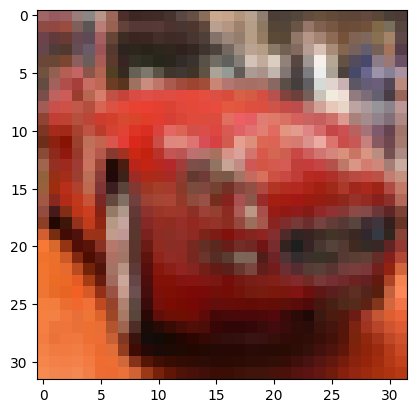

In [4]:
# Mostremos una imagen de ejemplo
plt.imshow(x_train[5]);

## Limpieza de datos

In [5]:
# Normalizamos los datos
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
num_classes = len(np.unique(y_train))
# Convertimos las etiquetas a one-hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## División de datos

In [10]:
# Dividimos los datos de entrenamiento en entrenamiento y validación
x_training, x_val = x_train[5000:], x_train[:5000]
y_training, y_val = y_train[5000:], y_train[:5000]

# Forma de los datos
print('x_training shape:', x_training.shape[0])
print('x_val shape:', x_val.shape[0])
print('x_test shape:', x_test.shape[0])


x_training shape: 45000
x_val shape: 5000
x_test shape: 10000


## Creación del modelo

In [11]:
base_filtros = 32 # Número de filtros base
kernel_size = (3, 3) # Tamaño de los filtros
w_regularizer = 1e-4 # Peso de la regularización

In [12]:
# Modelo secuencial
model = Sequential()
## Convolución 1
model.add(Conv2D(base_filtros, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer),
                    input_shape=x_training.shape[1:]))
model.add(Activation('relu')) # Función de activación
model.add(BatchNormalization()) # Normalización de los datos
## Convolución 2
model.add(Conv2D(base_filtros, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling
model.add(Dropout(0.2)) # Dropout del 20%
## Convolución 3
model.add(Conv2D(base_filtros * 2, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
## Convolución 4
model.add(Conv2D(base_filtros * 2, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
## Convolución 5
model.add(Conv2D(base_filtros * 4, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
## Convolución 6
model.add(Conv2D(base_filtros * 4, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
## Clasificación
model.add(Flatten()) # Aplanamos los datos
model.add(Dense(num_classes, activation='softmax')) # Capa de salida
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

## Compilación del modelo

In [14]:
model.compile(loss='categorical_crossentropy', # Función de pérdida
                optimizer='rmsprop', # Optimizador
                metrics=['accuracy']) # Métricas a monitorear

In [15]:
# Entrenamos el modelo
hist = model.fit(x_training, y_training, batch_size=32, epochs=100,
                    validation_data=(x_val, y_val),
                    verbose=2, shuffle=True)

Epoch 1/100
1407/1407 - 84s - loss: 1.8232 - accuracy: 0.4684 - val_loss: 1.3479 - val_accuracy: 0.5646 - 84s/epoch - 60ms/step
Epoch 2/100
1407/1407 - 49s - loss: 1.1688 - accuracy: 0.6386 - val_loss: 1.3973 - val_accuracy: 0.5720 - 49s/epoch - 35ms/step
Epoch 3/100
1407/1407 - 50s - loss: 0.9801 - accuracy: 0.6966 - val_loss: 1.0304 - val_accuracy: 0.6898 - 50s/epoch - 36ms/step
Epoch 4/100
1407/1407 - 50s - loss: 0.8913 - accuracy: 0.7308 - val_loss: 0.9868 - val_accuracy: 0.7092 - 50s/epoch - 35ms/step
Epoch 5/100
1407/1407 - 39s - loss: 0.8193 - accuracy: 0.7606 - val_loss: 1.1114 - val_accuracy: 0.6866 - 39s/epoch - 28ms/step
Epoch 6/100
1407/1407 - 37s - loss: 0.7749 - accuracy: 0.7777 - val_loss: 0.8228 - val_accuracy: 0.7646 - 37s/epoch - 27ms/step
Epoch 7/100
1407/1407 - 38s - loss: 0.7431 - accuracy: 0.7917 - val_loss: 1.2616 - val_accuracy: 0.6564 - 38s/epoch - 27ms/step
Epoch 8/100
1407/1407 - 38s - loss: 0.7164 - accuracy: 0.8014 - val_loss: 0.7387 - val_accuracy: 0.8032 

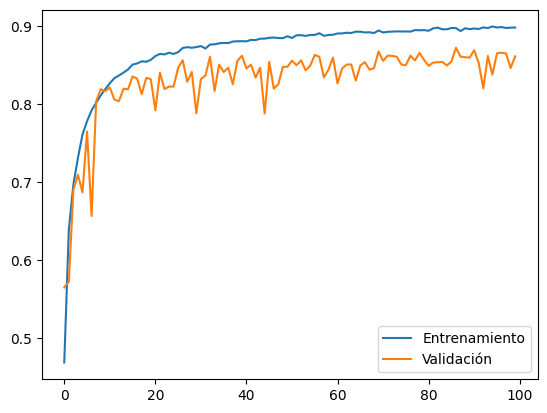

In [16]:
# Graficamos los resultados
plt.plot(hist.history['accuracy'], label='Entrenamiento')
plt.plot(hist.history['val_accuracy'], label='Validación')
plt.legend()
plt.show()

## Evaluación del modelo

In [21]:
# Evaluamos el modelo
model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 19ms/step - loss: 0.6885 - accuracy: 0.8529


[0.6884617209434509, 0.8529000282287598]